In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2, sqrt
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.image as mpimg
from torchvision.utils import save_image
import zipfile
import h5py
import pickle
import matplotlib.image as mpimg
import cv2
from skimage.metrics import structural_similarity as ssim
from scipy.linalg import sqrtm
import torch
import torchvision.transforms as transforms
from torchvision.models import inception_v3

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Extract the archive
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/New_Data/glioma.zip", 'r')
zip_ref.extractall("dataset/")
zip_ref.close()

In [ ]:
### Hyperparameters
DATASET = r"dataset"
#DATASET = r"C:\Users\mzlwm\OneDrive\Desktop\MEDGAN\dataset
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 300
LEARNING_RATE = 1e-3
BATCH_SIZE = 64
LOG_RESOLUTION = 8
Z_DIM = 256
W_DIM = 256
LAMBDA_GP = 10

In [ ]:
def get_loader():
    transform = transforms.Compose(
        [
            transforms.Resize((2 ** LOG_RESOLUTION, 2 ** LOG_RESOLUTION)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5, 0.5, 0.5],
                [0.5, 0.5, 0.5],
            ),
        ]
    )
    dataset = datasets.ImageFolder(root=DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )
    return loader

In [ ]:
class MappingNetwork(nn.Module):
    def __init__(self, z_dim, w_dim):
        super().__init__()
        self.mapping = nn.Sequential(
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim),
            nn.ReLU(),
            EqualizedLinear(z_dim, w_dim)
        )

    def forward(self, x):
        x = x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + 1e-8)  # for PixelNorm
        return self.mapping(x)


In [ ]:
class Generator(nn.Module):

    def __init__(self, log_resolution, W_DIM, n_features = 32, max_features = 256):

        super().__init__()

        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 2, -1, -1)]
        self.n_blocks = len(features)

        self.initial_constant = nn.Parameter(torch.randn((1, features[0], 4, 4)))

        self.style_block = StyleBlock(W_DIM, features[0], features[0])
        self.to_rgb = ToRGB(W_DIM, features[0])

        blocks = [GeneratorBlock(W_DIM, features[i - 1], features[i]) for i in range(1, self.n_blocks)]
        self.blocks = nn.ModuleList(blocks)

    def forward(self, w, input_noise):

        batch_size = w.shape[1]

        x = self.initial_constant.expand(batch_size, -1, -1, -1)
        x = self.style_block(x, w[0], input_noise[0][1])
        rgb = self.to_rgb(x, w[0])

        for i in range(1, self.n_blocks):
            x = F.interpolate(x, scale_factor=2, mode="bilinear")
            x, rgb_new = self.blocks[i - 1](x, w[i], input_noise[i])
            rgb = F.interpolate(rgb, scale_factor=2, mode="bilinear") + rgb_new

        return torch.tanh(rgb)

In [ ]:
class GeneratorBlock(nn.Module):

    def __init__(self, W_DIM, in_features, out_features):

        super().__init__()

        self.style_block1 = StyleBlock(W_DIM, in_features, out_features)
        self.style_block2 = StyleBlock(W_DIM, out_features, out_features)

        self.to_rgb = ToRGB(W_DIM, out_features)

    def forward(self, x, w, noise):

        x = self.style_block1(x, w, noise[0])
        x = self.style_block2(x, w, noise[1])

        rgb = self.to_rgb(x, w)

        return x, rgb


In [ ]:
class StyleBlock(nn.Module):

    def __init__(self, W_DIM, in_features, out_features):

        super().__init__()

        self.to_style = EqualizedLinear(W_DIM, in_features, bias=1.0)
        self.conv = Conv2dWeightModulate(in_features, out_features, kernel_size=3)
        self.scale_noise = nn.Parameter(torch.zeros(1))
        self.bias = nn.Parameter(torch.zeros(out_features))

        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x, w, noise):

        s = self.to_style(w)
        x = self.conv(x, s)
        if noise is not None:
            x = x + self.scale_noise[None, :, None, None] * noise
        return self.activation(x + self.bias[None, :, None, None])

In [ ]:
class ToRGB(nn.Module):

    def __init__(self, W_DIM, features):

        super().__init__()
        self.to_style = EqualizedLinear(W_DIM, features, bias=1.0)

        self.conv = Conv2dWeightModulate(features, 3, kernel_size=1, demodulate=False)
        self.bias = nn.Parameter(torch.zeros(3))
        self.activation = nn.LeakyReLU(0.2, True)

    def forward(self, x, w):

        style = self.to_style(w)
        x = self.conv(x, style)
        return self.activation(x + self.bias[None, :, None, None])

In [ ]:
class Conv2dWeightModulate(nn.Module):

    def __init__(self, in_features, out_features, kernel_size,
                 demodulate = True, eps = 1e-8):

        super().__init__()
        self.out_features = out_features
        self.demodulate = demodulate
        self.padding = (kernel_size - 1) // 2

        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        self.eps = eps

    def forward(self, x, s):

        b, _, h, w = x.shape

        s = s[:, None, :, None, None]
        weights = self.weight()[None, :, :, :, :]
        weights = weights * s

        if self.demodulate:
            sigma_inv = torch.rsqrt((weights ** 2).sum(dim=(2, 3, 4), keepdim=True) + self.eps)
            weights = weights * sigma_inv

        x = x.reshape(1, -1, h, w)

        _, _, *ws = weights.shape
        weights = weights.reshape(b * self.out_features, *ws)

        x = F.conv2d(x, weights, padding=self.padding, groups=b)

        return x.reshape(-1, self.out_features, h, w)


In [ ]:
class Discriminator(nn.Module):

    def __init__(self, log_resolution, n_features = 64, max_features = 256):

        super().__init__()

        features = [min(max_features, n_features * (2 ** i)) for i in range(log_resolution - 1)]

        self.from_rgb = nn.Sequential(
            EqualizedConv2d(3, n_features, 1),
            nn.LeakyReLU(0.2, True),
        )
        n_blocks = len(features) - 1
        blocks = [DiscriminatorBlock(features[i], features[i + 1]) for i in range(n_blocks)]
        self.blocks = nn.Sequential(*blocks)

        final_features = features[-1] + 1
        self.conv = EqualizedConv2d(final_features, final_features, 3)
        self.final = EqualizedLinear(2 * 2 * final_features, 1)

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x):

        x = self.from_rgb(x)
        x = self.blocks(x)

        x = self.minibatch_std(x)
        x = self.conv(x)
        x = x.reshape(x.shape[0], -1)
        return self.final(x)

In [ ]:
class DiscriminatorBlock(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()
        self.residual = nn.Sequential(nn.AvgPool2d(kernel_size=2, stride=2), # down sampling using avg pool
                                      EqualizedConv2d(in_features, out_features, kernel_size=1))

        self.block = nn.Sequential(
            EqualizedConv2d(in_features, in_features, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, True),
            EqualizedConv2d(in_features, out_features, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2, True),
        )

        self.down_sample = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        self.scale = 1 / sqrt(2)

    def forward(self, x):
        residual = self.residual(x)

        x = self.block(x)
        x = self.down_sample(x)

        return (x + residual) * self.scale

In [ ]:
class EqualizedLinear(nn.Module):

    def __init__(self, in_features, out_features, bias = 0.):

        super().__init__()
        self.weight = EqualizedWeight([out_features, in_features])
        self.bias = nn.Parameter(torch.ones(out_features) * bias)

    def forward(self, x: torch.Tensor):
        return F.linear(x, self.weight(), bias=self.bias)

In [ ]:
class EqualizedConv2d(nn.Module):

    def __init__(self, in_features, out_features,
                 kernel_size, padding = 0):

        super().__init__()
        self.padding = padding
        self.weight = EqualizedWeight([out_features, in_features, kernel_size, kernel_size])
        self.bias = nn.Parameter(torch.ones(out_features))

    def forward(self, x: torch.Tensor):
        return F.conv2d(x, self.weight(), bias=self.bias, padding=self.padding)

In [ ]:
class EqualizedWeight(nn.Module):

    def __init__(self, shape):

        super().__init__()

        self.c = 1 / sqrt(np.prod(shape[1:]))
        self.weight = nn.Parameter(torch.randn(shape))

    def forward(self):
        return self.weight * self.c

In [ ]:
class PathLengthPenalty(nn.Module):

    def __init__(self, beta):

        super().__init__()

        self.beta = beta
        self.steps = nn.Parameter(torch.tensor(0.), requires_grad=False)

        self.exp_sum_a = nn.Parameter(torch.tensor(0.), requires_grad=False)

    def forward(self, w, x):

        device = x.device
        image_size = x.shape[2] * x.shape[3]
        y = torch.randn(x.shape, device=device)

        output = (x * y).sum() / sqrt(image_size)
        sqrt(image_size)

        gradients, *_ = torch.autograd.grad(outputs=output,
                                            inputs=w,
                                            grad_outputs=torch.ones(output.shape, device=device),
                                            create_graph=True)

        norm = (gradients ** 2).sum(dim=2).mean(dim=1).sqrt()

        if self.steps > 0:

            a = self.exp_sum_a / (1 - self.beta ** self.steps)

            loss = torch.mean((norm - a) ** 2)
        else:
            loss = norm.new_tensor(0)

        mean = norm.mean().detach()
        self.exp_sum_a.mul_(self.beta).add_(mean, alpha=1 - self.beta)
        self.steps.add_(1.)

        return loss

In [ ]:
def gradient_penalty(critic, real, fake,device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


In [ ]:
def get_w(batch_size):

    z = torch.randn(batch_size, W_DIM).to(DEVICE)
    w = mapping_network(z)
    return w[None, :, :].expand(LOG_RESOLUTION, -1, -1)


In [ ]:
def get_noise(batch_size):

        noise = []
        resolution = 4

        for i in range(LOG_RESOLUTION):
            if i == 0:
                n1 = None
            else:
                n1 = torch.randn(batch_size, 1, resolution, resolution, device=DEVICE)
            n2 = torch.randn(batch_size, 1, resolution, resolution, device=DEVICE)

            noise.append((n1, n2))

            resolution *= 2

        return noise

In [ ]:
def save_models(gen, critic, mapping_net=None, save_dir="/content/drive/MyDrive/StyleGAN2-256/StyleGAN2-256-Glioma"):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Save as .pth
    torch.save(gen.state_dict(), os.path.join(save_dir, 'generator.pth'))
    torch.save(critic.state_dict(), os.path.join(save_dir, 'critic.pth'))
    # Save optimizer states
    if opt_gen:
        torch.save(opt_gen.state_dict(), os.path.join(save_dir, 'opt_gen.pth'))
    if opt_critic:
        torch.save(opt_critic.state_dict(), os.path.join(save_dir, 'opt_critic.pth'))
    if opt_mapping_network:
        torch.save(opt_mapping_network.state_dict(), os.path.join(save_dir, 'opt_mapping_net.pth'))
    if mapping_net:
        torch.save(mapping_net.state_dict(), os.path.join(save_dir, 'mapping_net.pth'))

    print(f"Models saved in .pth format at {save_dir}")

    # Save as .h5
    with h5py.File(os.path.join(save_dir, 'generator.h5'), 'w') as hf:
        for k, v in gen.state_dict().items():
            hf.create_dataset(k, data=v.cpu().numpy())

    with h5py.File(os.path.join(save_dir, 'critic.h5'), 'w') as hf:
        for k, v in critic.state_dict().items():
            hf.create_dataset(k, data=v.cpu().numpy())

    if mapping_net:
        with h5py.File(os.path.join(save_dir, 'mapping_net.h5'), 'w') as hf:
            for k, v in mapping_net.state_dict().items():
                hf.create_dataset(k, data=v.cpu().numpy())

    print(f"Models saved in .h5 format at {save_dir}")

    # Save as .pkl
    with open(os.path.join(save_dir, 'generator.pkl'), 'wb') as f:
        pickle.dump(gen.state_dict(), f)

    with open(os.path.join(save_dir, 'critic.pkl'), 'wb') as f:
        pickle.dump(critic.state_dict(), f)

    if mapping_net:
        with open(os.path.join(save_dir, 'mapping_net.pkl'), 'wb') as f:
            pickle.dump(mapping_net.state_dict(), f)

    print(f"Models saved in .pkl format at {save_dir}")


In [ ]:
def generate_examples(gen, epoch, n=100):
    gen.eval()
    alpha = 1.0
    base_dir = '/content/drive/MyDrive/StyleGAN2-256/StyleGAN2-256-Glioma/saved_examples'
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    epoch_dir = os.path.join(base_dir, f'epoch{epoch}')
    if not os.path.exists(epoch_dir):
        os.makedirs(epoch_dir)
    for i in range(n):
        with torch.no_grad():
            w = get_w(1)
            noise = get_noise(1)
            img = gen(w, noise)
            save_image(img * 0.5 + 0.5, os.path.join(epoch_dir, f"img_{i}.png"))

    gen.train()


In [ ]:
def train_fn(
    critic,
    gen,
    path_length_penalty,
    loader,
    opt_critic,
    opt_gen,
    opt_mapping_network,
):
    loop = tqdm(loader, leave=True)

    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        w     = get_w(cur_batch_size)
        noise = get_noise(cur_batch_size)
        with torch.cuda.amp.autocast():
            fake = gen(w, noise)
            critic_fake = critic(fake.detach())

            critic_real = critic(real)
            gp = gradient_penalty(critic, real, fake, device=DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        critic.zero_grad()
        loss_critic.backward()
        opt_critic.step()

        gen_fake = critic(fake)
        loss_gen = -torch.mean(gen_fake)

        if batch_idx % 16 == 0:
            plp = path_length_penalty(w, fake)
            if not torch.isnan(plp):
                loss_gen = loss_gen + plp

        mapping_network.zero_grad()
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        opt_mapping_network.step()

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )


In [ ]:
loader = get_loader()

gen = Generator(LOG_RESOLUTION, W_DIM).to(DEVICE)
critic = Discriminator(LOG_RESOLUTION).to(DEVICE)
mapping_network = MappingNetwork(Z_DIM, W_DIM).to(DEVICE)
path_length_penalty = PathLengthPenalty(0.99).to(DEVICE)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
opt_mapping_network = optim.Adam(mapping_network.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))

gen.train()
critic.train()
mapping_network.train()

MappingNetwork(
  (mapping): Sequential(
    (0): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (1): ReLU()
    (2): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (3): ReLU()
    (4): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (5): ReLU()
    (6): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (7): ReLU()
    (8): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (9): ReLU()
    (10): EqualizedLinear(
      (weight): EqualizedWeight()
    )
    (11): ReLU()
    (12): EqualizedLinear(
      (weight): EqualizedWeight()
    )
  )
)

In [ ]:
loader = get_loader()

for epoch in range(EPOCHS):
    train_fn(
        critic,
        gen,
        path_length_penalty,
        loader,
        opt_critic,
        opt_gen,
        opt_mapping_network,
    )
    if epoch % 50 == 0:
    	generate_examples(gen, epoch)

  0%|          | 0/26 [00:00<?, ?it/s]<ipython-input-23-5d0d6474a53b>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 26/26 [00:47<00:00,  1.82s/it, gp=0.0685, loss_critic=-9.13]


In [ ]:
generate_examples(gen, epoch)
save_models(gen, critic, mapping_net=mapping_network)

Models saved in .pth format at /content/drive/MyDrive/StyleGAN2-256/StyleGAN2-256-Glioma
Models saved in .h5 format at /content/drive/MyDrive/StyleGAN2-256/StyleGAN2-256-Glioma
Models saved in .pkl format at /content/drive/MyDrive/StyleGAN2-256/StyleGAN2-256-Glioma


In [33]:
# Specify the epoch you want to visualize
epoch_to_visualize = EPOCHS - 1  # Visualize the last epoch

# Directory containing the generated images for the specified epoch
image_dir = f"/content/drive/MyDrive/StyleGAN2-256/StyleGAN2-256-Glioma/saved_examples/epoch{epoch_to_visualize}"

# Check if the directory exists
if not os.path.exists(image_dir):
    print(f"Error: Directory '{image_dir}' not found. Please run the training script to generate images.")
else:
    # List all image files in the directory
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(10, 10, figsize=(20, 20))

    # Iterate through the image files and display them in the subplots
    for i, image_file in enumerate(image_files[:100]):  # Display up to 100 images
        image_path = os.path.join(image_dir, image_file)
        img = mpimg.imread(image_path)
        row = i // 10
        col = i % 10
        axes[row, col].imshow(img)
        axes[row, col].axis("off")  # Turn off axis labels and ticks

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

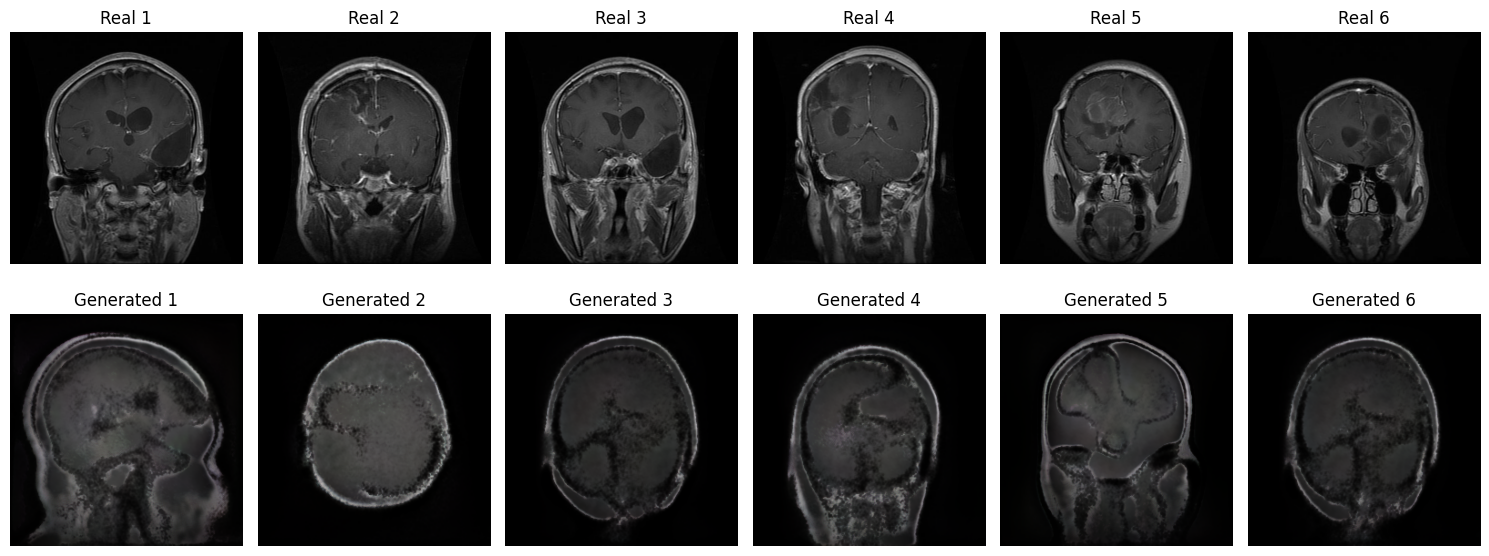

In [ ]:
# Specify the epoch you want to visualize
epoch_to_visualize = EPOCHS # Visualize the last epoch

# Directories containing the generated and real images
generated_image_dir = f"/content/drive/MyDrive/StyleGAN2-256/StyleGAN2-256-Glioma/saved_examples/epoch{epoch_to_visualize}"
real_image_dir = "/content/drive/MyDrive/ProGAN-256/real_examples/glioma" # Replace with the actual directory of your real images


# Check if the directories exist
if not os.path.exists(generated_image_dir):
    print(f"Error: Directory '{generated_image_dir}' not found.")
elif not os.path.exists(real_image_dir):
    print(f"Error: Directory '{real_image_dir}' not found.")
else:
    # Get a list of image files (you might need to adjust the file extension)
    generated_image_files = [f for f in os.listdir(generated_image_dir) if f.endswith(".png")][:6]
    real_image_files = [f for f in os.listdir(real_image_dir) if f.endswith(".jpg")][:6] # Assuming JPGs, adjust if different

    # Create a figure and axes for the subplots
    fig, axes = plt.subplots(2, 6, figsize=(15, 6))

    # Display real images
    for i, image_file in enumerate(real_image_files):
        image_path = os.path.join(real_image_dir, image_file)
        img = mpimg.imread(image_path)
        axes[0, i].imshow(img)
        axes[0, i].set_title(f"Real {i+1}")
        axes[0, i].axis("off")


    # Display generated images
    for i, image_file in enumerate(generated_image_files):
        image_path = os.path.join(generated_image_dir, image_file)
        img = mpimg.imread(image_path)
        axes[1, i].imshow(img)
        axes[1, i].set_title(f"Generated {i+1}")
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.show()

In [34]:
# Function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# Function to calculate Dice Score
def calculate_dice_score(img1, img2):
    img1_flat = img1.flatten()
    img2_flat = img2.flatten()
    intersection = np.sum(img1_flat * img2_flat)
    return (2.0 * intersection) / (np.sum(img1_flat) + np.sum(img2_flat))

# Function to calculate SSIM
def calculate_ssim(img1, img2):
    return ssim(img1, img2)

# Function to calculate FID
def calculate_fid(real_features, generated_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Function to calculate Inception Score (IS)
def calculate_inception_score(predictions, splits=10):
    # Split predictions into batches
    split_scores = []
    for k in range(splits):
        part = predictions[k * (len(predictions) // splits): (k + 1) * (len(predictions) // splits)]
        p_y = np.mean(part, axis=0)
        scores = [F.kl_div(torch.log(torch.tensor(p_y, dtype=torch.float32)), torch.tensor(p, dtype=torch.float32), reduction='batchmean').item() for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return np.mean(split_scores), np.std(split_scores)

# Initialize pre-trained Inception v3 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.fc = torch.nn.Identity()  # Remove final classification layer
inception_model.eval().to(device)

# Transform for input images to the Inception model
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Directories containing real and generated images
real_images_dir = "/content/drive/MyDrive/StyleGAN2-256/real_examples/glioma"  # Adjust path as necessary
generated_images_dir = "/content/drive/MyDrive/StyleGAN2-256/StyleGAN2-256-Glioma/saved_examples/epoch300"  # Adjust path as necessary

# Initialize metrics
total_psnr = 0.0
total_ssim = 0.0
total_dice = 0.0
real_features = []
generated_features = []
generated_predictions = []
num_images = 0

# Process images
for i in range(10, 101):  # Images are named Tr-gl_0010 to Tr-gl_0100
    # Define paths for real and generated images
    real_image_path = os.path.join(real_images_dir, f"Tr-gl_{i:04d}.jpg")
    generated_image_path = os.path.join(generated_images_dir, f"img_{i - 10}.png")  # Adjust index for generated images

    # Check if both files exist
    if os.path.exists(real_image_path) and os.path.exists(generated_image_path):
        # Load and preprocess real image
        real_image = cv2.imread(real_image_path)
        real_image_gray = cv2.cvtColor(real_image, cv2.COLOR_BGR2GRAY)
        real_image_resized = cv2.resize(real_image_gray, (128, 128))
        real_image_tensor = transform(real_image).unsqueeze(0).to(device)

        # Load and preprocess generated image
        generated_image = cv2.imread(generated_image_path)
        generated_image_gray = cv2.cvtColor(generated_image, cv2.COLOR_BGR2GRAY)
        generated_image_resized = cv2.resize(generated_image_gray, (128, 128))
        generated_image_tensor = transform(generated_image).unsqueeze(0).to(device)

        # Calculate metrics
        psnr_value = calculate_psnr(real_image_resized, generated_image_resized)
        ssim_value = calculate_ssim(real_image_resized, generated_image_resized)
        dice_value = calculate_dice_score(real_image_resized, generated_image_resized)

        # Extract features and predictions using Inception model
        with torch.no_grad():
            real_feature = inception_model(real_image_tensor).cpu().numpy()
            generated_feature = inception_model(generated_image_tensor).cpu().numpy()
            generated_prediction = F.softmax(inception_model(generated_image_tensor), dim=1).cpu().numpy()

            real_features.append(real_feature)
            generated_features.append(generated_feature)
            generated_predictions.append(generated_prediction)

        # Accumulate metrics
        total_psnr += psnr_value
        total_ssim += ssim_value
        total_dice += dice_value
        num_images += 1
    else:
        # Log missing files
        print(f"Missing: Real: {real_image_path}, Generated: {generated_image_path}")

# Calculate averages
if num_images > 0:
    average_psnr = total_psnr / num_images
    average_ssim = total_ssim / num_images
    average_dice = total_dice / num_images

    # Calculate FID
    real_features = np.vstack(real_features)
    generated_features = np.vstack(generated_features)
    fid_value = calculate_fid(real_features, generated_features)

    # Calculate Inception Score
    generated_predictions = np.vstack(generated_predictions)
    inception_score_mean, inception_score_std = calculate_inception_score(generated_predictions)

    # Display results
    print(f"Processed {num_images} images.")
    print(f"Average PSNR: {average_psnr:.2f}")
    print(f"Average SSIM: {average_ssim:.2f}")
    print(f"Average Dice Score: {average_dice:.2f}")
    print(f"FID: {fid_value:.2f}")
    print(f"Inception Score: {inception_score_mean:.2f} ± {inception_score_std:.2f}")
else:
    print("No valid images found to process.")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Processed 91 images.
Average PSNR: 30.49
Average SSIM: 0.37
Average Dice Score: 2.31
FID: 236.62
Inception Score: 1.00 ± 0.00


In [ ]:
# Function to calculate PSNR
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

# Function to calculate Dice Score
def calculate_dice_score(img1, img2):
    img1_flat = img1.flatten()
    img2_flat = img2.flatten()
    intersection = np.sum(img1_flat * img2_flat)
    return (2.0 * intersection) / (np.sum(img1_flat) + np.sum(img2_flat))

# Function to calculate SSIM
def calculate_ssim(img1, img2):
    return ssim(img1, img2)

# Function to calculate FID
def calculate_fid(real_features, generated_features):
    mu1, sigma1 = real_features.mean(axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = generated_features.mean(axis=0), np.cov(generated_features, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Function to calculate Inception Score (IS)
def calculate_inception_score(predictions, splits=10):
    # Split predictions into batches
    split_scores = []
    for k in range(splits):
        part = predictions[k * (len(predictions) // splits): (k + 1) * (len(predictions) // splits)]
        p_y = np.mean(part, axis=0)
        scores = [F.kl_div(torch.log(torch.tensor(p_y, dtype=torch.float32)), torch.tensor(p, dtype=torch.float32), reduction='batchmean').item() for p in part]
        split_scores.append(np.exp(np.mean(scores)))
    return np.mean(split_scores), np.std(split_scores)

# Initialize pre-trained Inception v3 model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
inception_model = inception_v3(pretrained=True, transform_input=False)
inception_model.fc = torch.nn.Identity()  # Remove final classification layer
inception_model.eval().to(device)

# Transform for input images to the Inception model
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Directories containing real and generated images
real_images_dir = "/content/drive/MyDrive/StyleGAN2-256/real_examples/glioma"  # Adjust path as necessary
generated_images_dir = "/content/drive/MyDrive/StyleGAN2-256/StyleGAN2-256-Glioma/saved_examples/epoch300"  # Adjust path as necessary

# Initialize metrics
total_psnr = 0.0
total_ssim = 0.0
total_dice = 0.0
real_features = []
generated_features = []
generated_predictions = []
num_images = 0

# Process images
for i in range(10, 101):  # Images are named Tr-gl_0010 to Tr-gl_0100
    # Define paths for real and generated images
    real_image_path = os.path.join(real_images_dir, f"Tr-gl_{i:04d}.jpg")
    generated_image_path = os.path.join(generated_images_dir, f"img_{i - 10}.png")  # Adjust index for generated images

    # Check if both files exist
    if os.path.exists(real_image_path) and os.path.exists(generated_image_path):
        # Load and preprocess real image
        real_image = cv2.imread(real_image_path)
        real_image_gray = cv2.cvtColor(real_image, cv2.COLOR_BGR2GRAY)
        real_image_resized = cv2.resize(real_image_gray, (256, 256))
        real_image_tensor = transform(real_image).unsqueeze(0).to(device)

        # Load and preprocess generated image
        generated_image = cv2.imread(generated_image_path)
        generated_image_gray = cv2.cvtColor(generated_image, cv2.COLOR_BGR2GRAY)
        generated_image_resized = cv2.resize(generated_image_gray, (256, 256))
        generated_image_tensor = transform(generated_image).unsqueeze(0).to(device)

        # Calculate metrics
        psnr_value = calculate_psnr(real_image_resized, generated_image_resized)
        ssim_value = calculate_ssim(real_image_resized, generated_image_resized)
        dice_value = calculate_dice_score(real_image_resized, generated_image_resized)

        # Extract features and predictions using Inception model
        with torch.no_grad():
            real_feature = inception_model(real_image_tensor).cpu().numpy()
            generated_feature = inception_model(generated_image_tensor).cpu().numpy()
            generated_prediction = F.softmax(inception_model(generated_image_tensor), dim=1).cpu().numpy()

            real_features.append(real_feature)
            generated_features.append(generated_feature)
            generated_predictions.append(generated_prediction)

        # Accumulate metrics
        total_psnr += psnr_value
        total_ssim += ssim_value
        total_dice += dice_value
        num_images += 1
    else:
        # Log missing files
        print(f"Missing: Real: {real_image_path}, Generated: {generated_image_path}")

# Calculate averages
if num_images > 0:
    average_psnr = total_psnr / num_images
    average_ssim = total_ssim / num_images
    average_dice = total_dice / num_images

    # Calculate FID
    real_features = np.vstack(real_features)
    generated_features = np.vstack(generated_features)
    fid_value = calculate_fid(real_features, generated_features)

    # Calculate Inception Score
    generated_predictions = np.vstack(generated_predictions)
    inception_score_mean, inception_score_std = calculate_inception_score(generated_predictions)

    # Display results
    print(f"Processed {num_images} images.")
    print(f"Average PSNR: {average_psnr:.2f}")
    print(f"Average SSIM: {average_ssim:.2f}")
    print(f"Average Dice Score: {average_dice:.2f}")
    print(f"FID: {fid_value:.2f}")
    print(f"Inception Score: {inception_score_mean:.2f} ± {inception_score_std:.2f}")
else:
    print("No valid images found to process.")


Processed 91 images.
Average PSNR: 30.49
Average SSIM: 0.44
Average Dice Score: 2.30
FID: 236.62
Inception Score: 1.00 ± 0.00


In [ ]:
print